<a href="https://colab.research.google.com/github/PaoloSani/SASP-Project/blob/main/Speech_dereverberation_using_Cepstrum_alanysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import IPython.display as ipd
import soundfile as sf
import scipy.signal 

plt.style.use('seaborn')

# **Load the clean voice recording**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# path to the folder in drive
path = "/content/drive/MyDrive/SASP Project" # this should be the path to your Drive folder, where you loaded the files

In [ ]:
voice, Fs = librosa.load(path + "/Harvard list 01.wav", sr=8000)


In [ ]:
ipd.display(ipd.Audio(voice, rate=Fs))

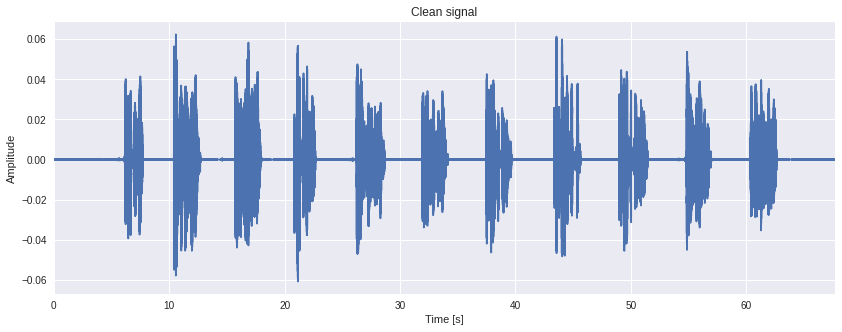

In [ ]:
voice_length = voice.shape[-1]
t_instants = np.arange(0,voice_length) / Fs
final_duration = voice_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,voice)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [ ]:
t_start = int(np.ceil(10.3*Fs))
t_end = int(np.ceil(12.8*Fs))
signal_dry = voice[t_start:t_end]     # shorten the original audio file

In [ ]:
ipd.display(ipd.Audio(signal_dry, rate=Fs))

In [ ]:
signal_dry_length = signal_dry.shape[-1]
t_instants = np.arange(0,signal_dry_length) / Fs
final_duration = signal_dry_length/Fs


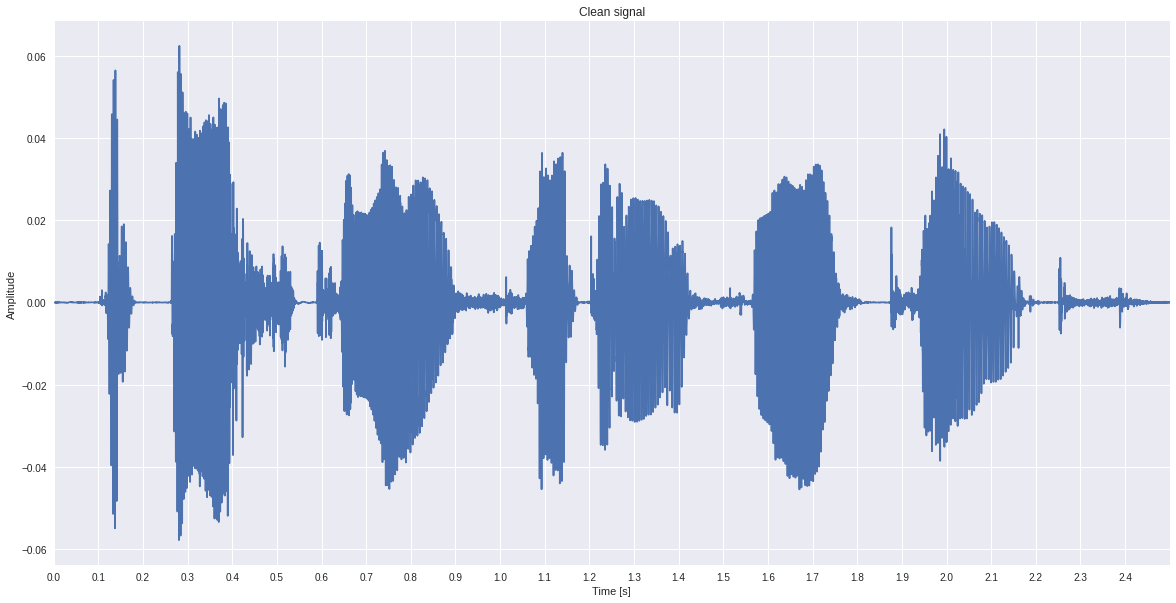

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(t_instants, signal_dry)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)
plt.xticks(np.arange(0, (final_duration), 0.1));


# **Long RIR audio file creation**

In [ ]:
ir, Fs_ir = librosa.load(path + "/spokane_womans_club_ir.wav", sr=8000, mono=False)
ipd.display(ipd.Audio(ir, rate=Fs))

In [ ]:
signal_wet = np.array([np.convolve(signal_dry, ir[0,:]),
              np.convolve(signal_dry, ir[1,:])]).T

# normalize the obtained audio
signal_wet = signal_wet / np.max(signal_wet)

# shorten the file 
t_end = int(np.ceil(4.4*Fs))
signal_wet = signal_wet[0:t_end]
signal_wet.shape 


(35200, 2)

In [ ]:
ipd.display(ipd.Audio(signal_wet.T, rate=Fs))

Finally, save the new reverbered file:


In [ ]:
sf.write(path+"/sim_rev_long.wav", signal_wet, samplerate=Fs)

#**Short RIR audio file creation**


In [ ]:
% pip install pyroomacoustics

     |████████████████████████████████| 1.1 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.5.0-cp37-cp37m-linux_x86_64.whl size=9720454 sha256=8ea39852ffb82243c523390139ee4d9a327653fcc8c24ec985cf0ba2680964d8
  Stored in directory: /root/.cache/pip/wheels/73/30/ca/a88fac6fba8c90101f115ee4c54b4579ad908665d8b96942f5
Successfully built pyroomacoustics


The following code source is [here](https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html).

We only adapted the desired audio to process.

The desired RT60 was 0.3
The measured RT60 is 0.402875


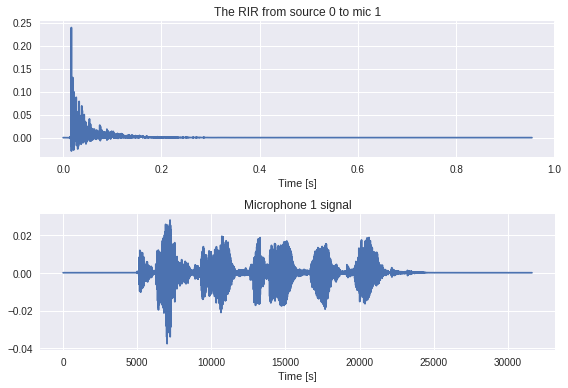

In [ ]:
import pyroomacoustics as pra
from scipy.io import wavfile

# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
fs = Fs
audio = signal_dry

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], [6.3, 4.93, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()

room.mic_array.to_wav(
    f"voice_rev.wav",
    norm=True,
    bitdepth=np.int16,
)


voice_rev, Fs = librosa.load("voice_rev.wav", sr=None)

ipd.display(ipd.Audio(voice_rev, rate=Fs))

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")

# plot signal at microphone 1
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

The file is now uploaded to our file folder in Colab, so we load it with Librosa and save it in the Drive folder.

In [ ]:
signal, Fs = librosa.load("voice_rev.wav", sr=None)


In [ ]:
sf.write(path+"/sim_rev_short.wav", signal, samplerate=Fs)

# **Process the audio file**

In [ ]:
# file_to_load = "/sim_rev_long.wav"
# tag = '_long' 
 
file_to_load = "/sim_rev_short.wav"
tag = '_short' # for writing correctly on the drive

In [ ]:
# load the audio file (as MONO)
signal, Fs = librosa.load(path + file_to_load, sr=None)

ipd.display(ipd.Audio(signal, rate=Fs))

In order to match the timestamps taken from the original clean signal, we shorten the reverbed audio file accordingly.

In [ ]:
# short reverb
t_start = int(np.ceil(0.50*Fs))
t_end = int(np.ceil(3.25*Fs))
signal = signal[t_start:t_end]

# # long real reverb
# t_start = int(np.ceil(0.15*Fs))
# t_end = int(np.ceil(3.25*Fs))
# signal = signal[t_start:t_end]

In [ ]:
signal_length = len(signal)

t_instants = np.arange(0,signal_length) / Fs
final_duration = signal_length/Fs


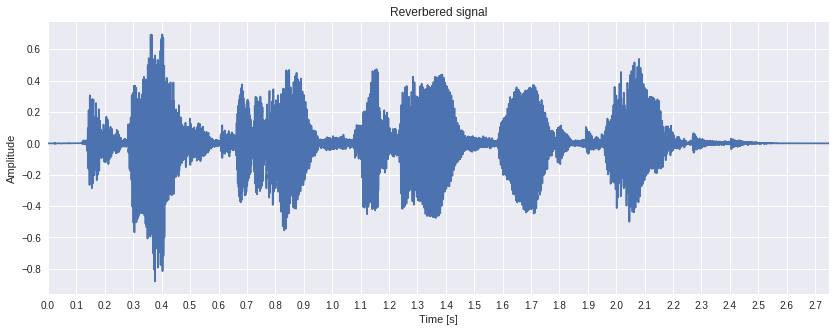

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(t_instants,signal)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Reverbered signal');
plt.autoscale(enable=True, axis= 'x', tight =True)
plt.xticks(np.arange(0, (final_duration), 0.1));


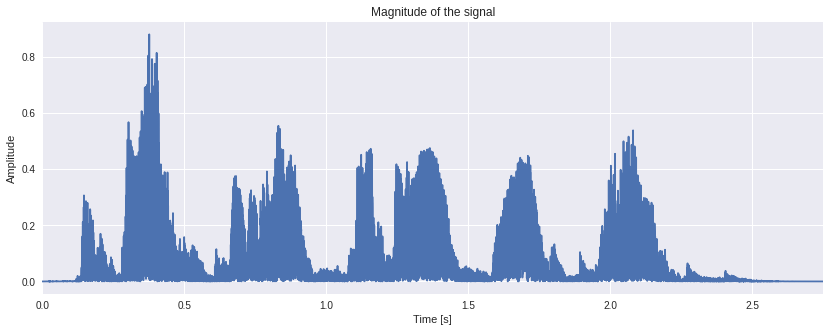

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(t_instants,np.abs(signal))
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Magnitude of the signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

##**Time domain processing: segmentation and windowing**

After some preliminary analysis we are now ready to perform segmentation and Cepstrum processing.

In [ ]:
# SEGMENTATION by eye
segments = np.vstack([
[0.1,   0.2],
[0.25,  0.56],
[0.57,  1.07] ,
[1.08,  1.16],
[1.17,  1.56],
[1.56,  1.83],
[1.85,  2.2],
[2.25,  2.46]])
len(segments[:,0])

num_frames = segments.shape[0]
num_frames

8

In [ ]:
# auxiliary function
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [ ]:
limits_idx = np.zeros((num_frames,2))

start_idx = (segments[:,0]*Fs).astype(int)
stop_idx = (segments[:,1]*Fs).astype(int)
limits_idx = np.vstack([start_idx, stop_idx])
print('limits_idx: ', limits_idx) 

durations = (limits_idx[1,:] - limits_idx[0,:])

durations = list(map(nextpow2, durations))
print('durations: ', durations)

max_frame_size = np.max(durations);

frames = np.zeros((num_frames,max_frame_size));
limits_idx[1,:] = limits_idx[0,:] + durations;


limits_idx:  [[  800  2000  4560  8640  9360 12480 14800 18000]
 [ 1600  4480  8560  9280 12480 14640 17600 19680]]
durations:  [1024, 4096, 4096, 1024, 4096, 4096, 4096, 2048]


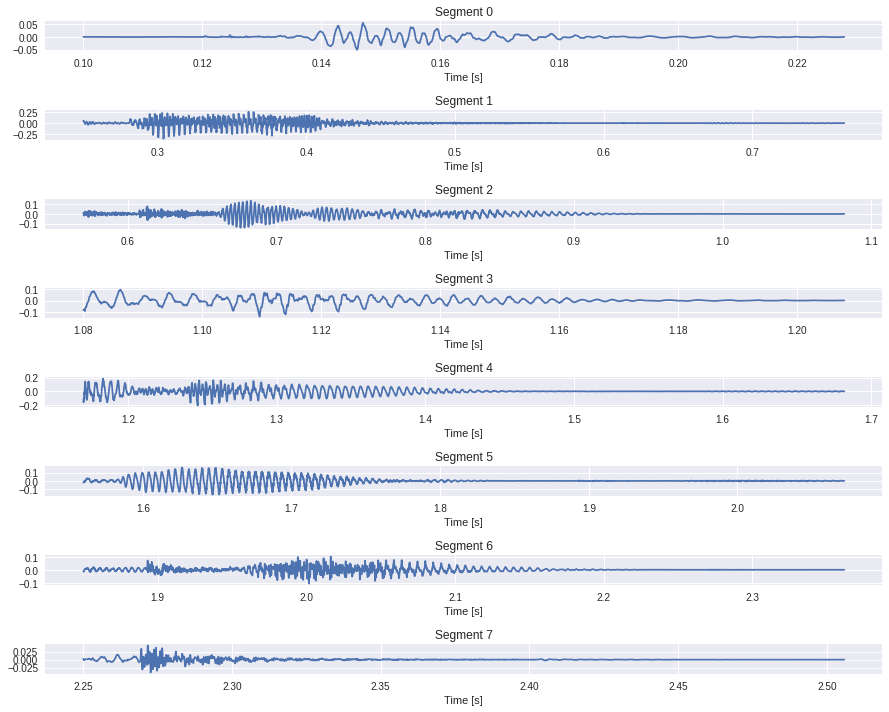

In [ ]:
plt.figure(figsize=(15,12))
for i in range(num_frames):
  plt.subplot(num_frames,1,i+1);


  t = t_instants[limits_idx[0,i] : limits_idx[1,i]];

  frame = signal[limits_idx[0,i] : limits_idx[1,i]];
  frames[i, 0:durations[i]] = frame;
  
  tau = -(len(frame)-1) / np.log(0.01)

  win = scipy.signal.windows.exponential(len(frame),center=0, tau=tau,sym=False) # exponential asymmetric window

  frame = win*frame

  plt.plot(t, frame)
  plt.xlabel('Time [s]')
  plt.title('Segment {}' .format(i))
  plt.subplots_adjust(hspace=2)
  plt.subplots_adjust(wspace = 0.5)


##**Cepstrum Processing**

In [ ]:
def complex_cepstrum(x, n=None, unwrap=False):
    def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples+1)//2
        if samples == 1: 
            center = 0 
        ndelay = np.array(np.round(unwrapped[...,center]/np.pi))
        unwrapped -= np.pi * ndelay[...,None] * np.arange(samples) / center
        return unwrapped, ndelay
         
    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    if ( unwrap ):
      log_spectrum = np.log(np.abs(spectrum)+np.finfo(float).eps) + 1j*unwrapped_phase
    else :
      log_spectrum = np.log(spectrum+np.finfo(float).eps) # complex logarithm
    # ceps = np.fft.ifft(log_spectrum).real
    ceps = np.fft.ifft(log_spectrum)
     
    return ceps, ndelay

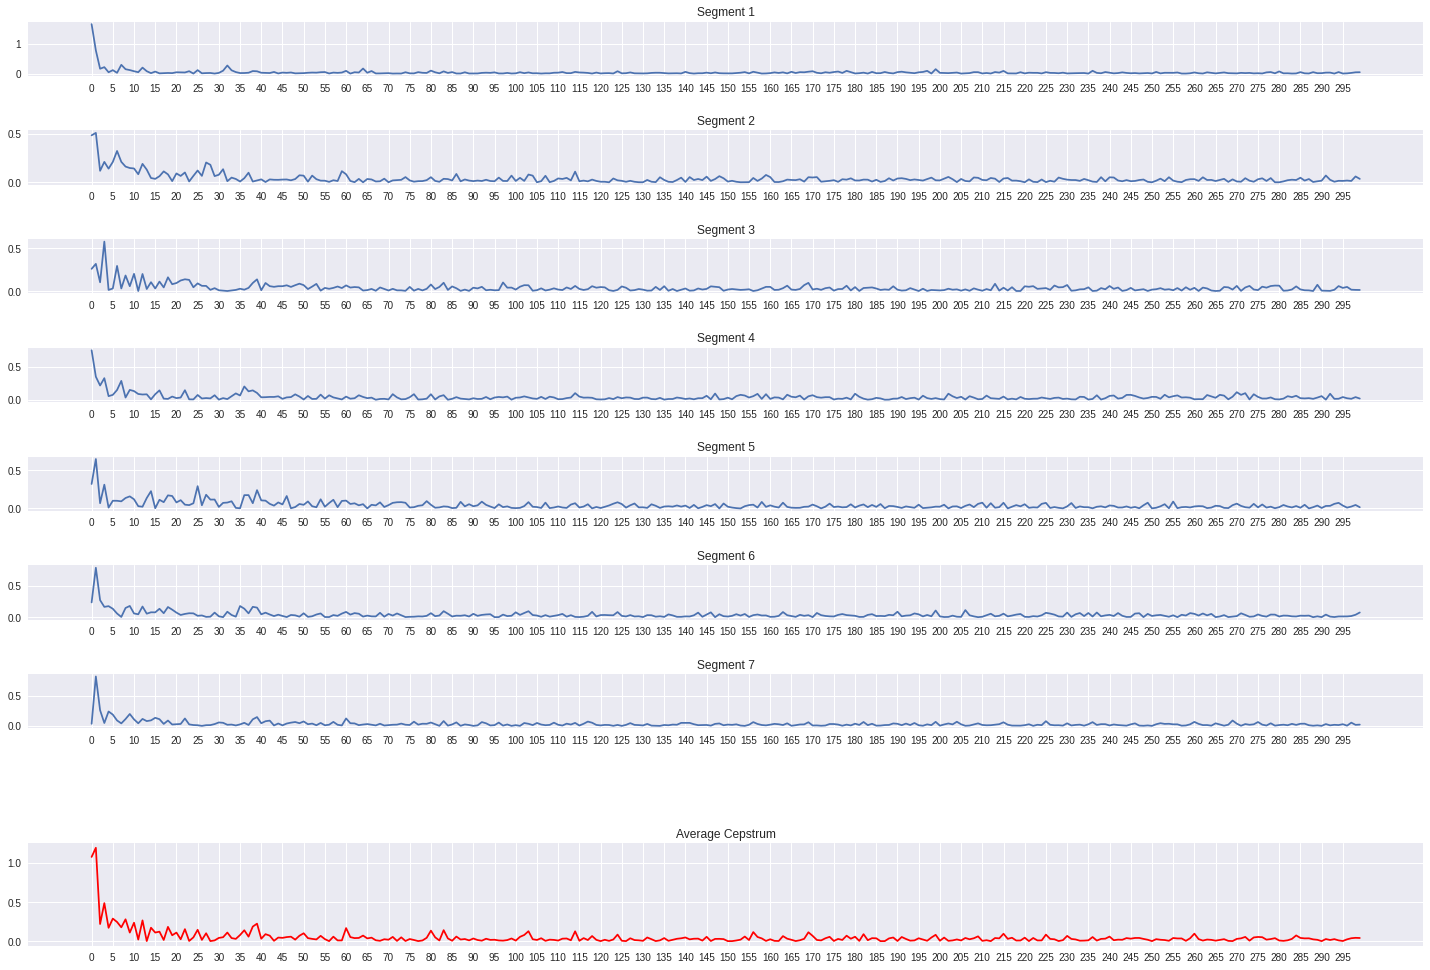

In [ ]:
max_quefrency_bin = 300
avg_Cepstrum = np.zeros((num_frames, max_quefrency_bin), dtype = 'complex_')

plt.figure(figsize=(25,17))
for i in range(len(segments)):
  plt.subplot(num_frames+1,1,i+1);
  Cepstrum, _ = complex_cepstrum(frames[i, :])
 
  Cepstrum = Cepstrum[0:max_quefrency_bin];
  quefrency = range(len(Cepstrum));
  plt.plot(quefrency,abs(Cepstrum))
  avg_Cepstrum[i,:] = Cepstrum;
  plt.title("Segment {}" .format(i+1));
  plt.xticks(np.arange(0, max_quefrency_bin, 5));


avg_Cepstrum = np.sum(avg_Cepstrum,0)/4;
plt.subplot(5,1,5)
plt.plot(quefrency, np.abs(avg_Cepstrum), 'r');
plt.title("Average Cepstrum");
plt.subplots_adjust(hspace=1)
plt.subplots_adjust(wspace = 0.5)
plt.xticks(np.arange(0, max_quefrency_bin, 5));


In [ ]:
full_Cepstrum, _ = complex_cepstrum(signal) # full complex cepstrum of the whole signal

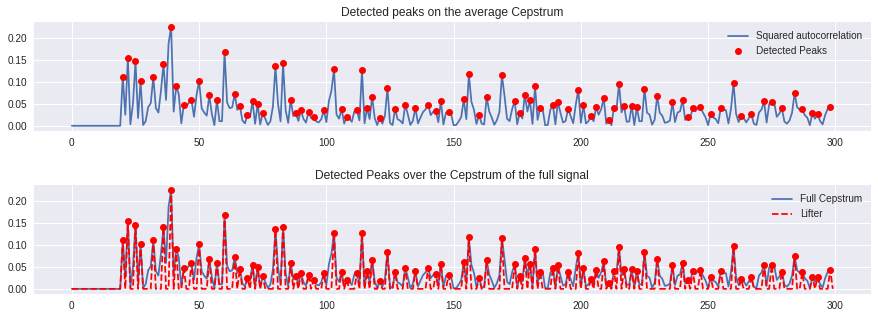

In [30]:
# # Peaks detection
# autocorr_avgcepstrum = scipy.signal.correlate(avg_Cepstrum,avg_Cepstrum)
# autocorr_avgcepstrum = autocorr_avgcepstrum[max_quefrency_bin-2:-1]

high_time_lifter = np.ones((max_quefrency_bin))
high_time_lifter[0:20] = 0    # the first 20 quefrency peaks are related to speech, so we exclude them from our analysis 

# autocorr_avgcepstrum = autocorr_avgcepstrum*high_time_lifter

# autocorr_squared = np.power(autocorr_avgcepstrum,2)
# thresh = np.mean(abs(autocorr_avgcepstrum))
# peaks,_ = scipy.signal.find_peaks(abs(autocorr_squared),height=0.01)

avg_Cepstrum = high_time_lifter*avg_Cepstrum
peaks,_ = scipy.signal.find_peaks(abs(avg_Cepstrum),height=0.01)

# Lifter definition
lifter = np.zeros((len(signal),),dtype='complex')
lifter[peaks] = avg_Cepstrum[peaks]

plt.figure(4,(15,8))

plt.subplot(3,1,1)
plt.plot(abs(avg_Cepstrum))
plt.plot(peaks,abs(avg_Cepstrum[peaks]),'ro');
plt.title('Detected peaks on the average Cepstrum')
plt.legend(["Squared autocorrelation","Detected Peaks"])
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace = 0.5)

quefrency_full = np.arange(0, len(signal))
plt.subplot(3,1,2)
plt.plot(quefrency,abs(avg_Cepstrum));
plt.plot(quefrency, abs(lifter[0:max_quefrency_bin]),'r--');
plt.plot(peaks,abs(avg_Cepstrum[peaks]),'ro');
plt.title('Detected Peaks over the Cepstrum of the full signal')
plt.legend(["Full Cepstrum","Lifter"]);

Text(0.5, 1.0, 'Cepstrum Pre and after Liftering')

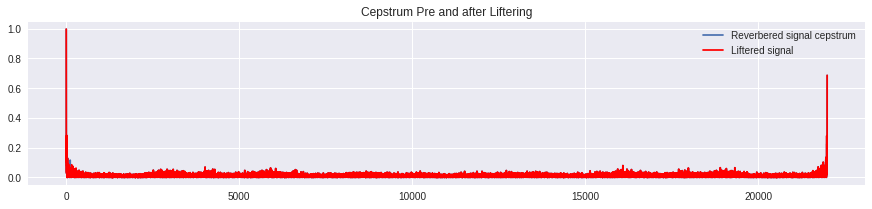

In [ ]:
# Liftering
liftered_cepstrum = full_Cepstrum - lifter 

plt.figure(5,(15,3))
plt.plot(abs(full_Cepstrum));
plt.plot(abs(liftered_cepstrum),'r');
plt.legend(["Reverbered signal cepstrum","Liftered signal"]);
plt.title('Cepstrum Pre and after Liftering')


In [ ]:
# Back to the time domain

dereverbered_signal = np.fft.ifft(np.power(np.e,np.fft.fft(liftered_cepstrum))) 

##**Final Result**

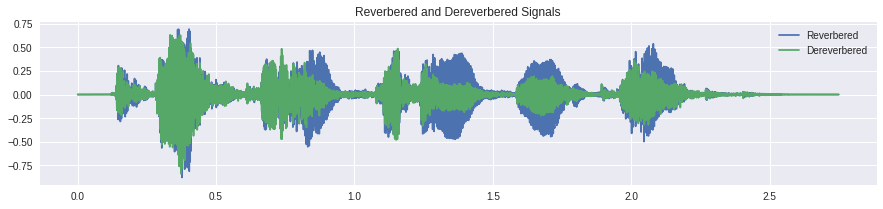

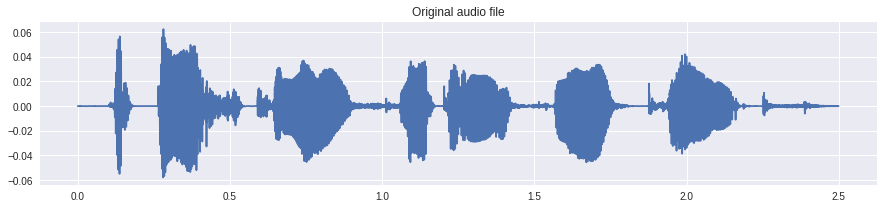

In [ ]:
plt.figure(6,(15,3))
plt.plot(t_instants,signal)
plt.title('Reverbered and Dereverbered Signals')
plt.plot(t_instants,np.real(dereverbered_signal))
plt.legend(["Reverbered","Dereverbered"]);
plt.grid('minor')

plt.figure(figsize=(15,3))
plt.plot(t_instants[:len(signal_dry)], signal_dry)
plt.title('Original audio file')


ipd.display(ipd.Audio(np.real(dereverbered_signal), rate=Fs))
ipd.display(ipd.Audio(np.real(signal), rate=Fs))
ipd.display(ipd.Audio(signal_dry, rate=Fs))

Finally we write the result on the Drive folder.

In [ ]:
sf.write(path+"/result" + tag + ".wav", np.real(dereverbered_signal), samplerate=Fs)

In [ ]:
signal, Fs = librosa.load(path + "/result" + tag + ".wav", sr=None, mono=False)

ipd.display(ipd.Audio(signal, rate=Fs))